In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


In [2]:
train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')

In [3]:
train_df.tail()

,row_id,time,x,y,direction,congestion
848830,848830,1991-09-30 11:40:00,2,3,NB,54
848831,848831,1991-09-30 11:40:00,2,3,NE,28
848832,848832,1991-09-30 11:40:00,2,3,SB,68
848833,848833,1991-09-30 11:40:00,2,3,SW,17
848834,848834,1991-09-30 11:40:00,2,3,WB,24


In [4]:
train_df['time'] = pd.to_datetime(train_df['time'])

In [5]:
train_df['month'] = train_df['time'].dt.month
train_df['day'] = train_df['time'].dt.day
train_df['hour'] = train_df['time'].dt.hour
train_df['week'] = train_df['time'].dt.dayofweek
train_df = train_df.drop(['time', 'row_id'],axis=1)

train_df.head()

,x,y,direction,congestion,month,day,hour,week
0,0,0,EB,70,4,1,0,0
1,0,0,NB,49,4,1,0,0
2,0,0,SB,24,4,1,0,0
3,0,1,EB,18,4,1,0,0
4,0,1,NB,60,4,1,0,0


In [6]:
train_df['direction'] = train_df['direction'].astype(str)
train_df = pd.get_dummies(train_df,columns=['direction'])

In [7]:
train_df

,x,y,congestion,month,day,hour,week,direction_EB,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB
0,0,0,70,4,1,0,0,1,0,0,0,0,0,0,0
1,0,0,49,4,1,0,0,0,1,0,0,0,0,0,0
2,0,0,24,4,1,0,0,0,0,0,0,1,0,0,0
3,0,1,18,4,1,0,0,1,0,0,0,0,0,0,0
4,0,1,60,4,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,2,3,54,9,30,11,0,0,1,0,0,0,0,0,0
848831,2,3,28,9,30,11,0,0,0,1,0,0,0,0,0
848832,2,3,68,9,30,11,0,0,0,0,0,1,0,0,0
848833,2,3,17,9,30,11,0,0,0,0,0,0,0,1,0


In [8]:
train_df = train_df.sample(frac=0.8,random_state=0)
test_df = train_df.drop(train_df.index)

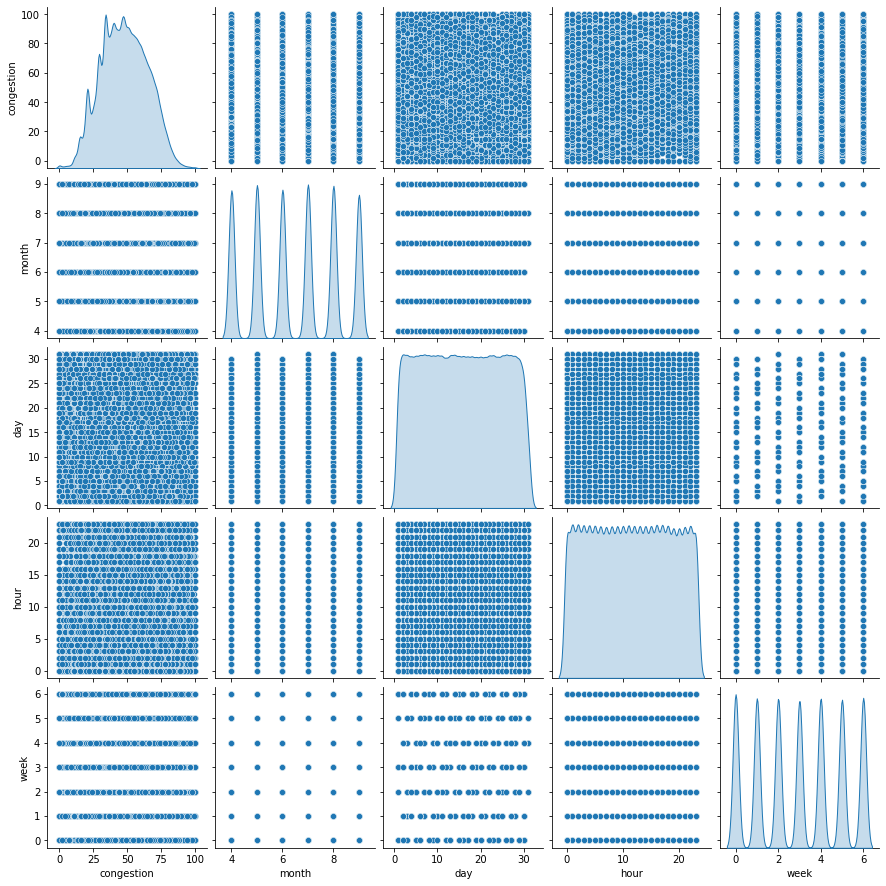

In [9]:
sns.pairplot(train_df[["congestion", "month", "day", "hour", "week"]], diag_kind="kde")

In [10]:
train_stats = train_df.describe()
train_stats.pop("congestion")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
x,679068.0,1.138558,0.801600,0.0,0.0,1.0,2.0,2.0
y,679068.0,1.630333,1.089349,0.0,1.0,2.0,3.0,3.0
month,679068.0,6.489299,1.695247,4.0,5.0,7.0,8.0,9.0
day,679068.0,15.693051,8.793913,1.0,8.0,16.0,23.0,31.0
hour,679068.0,11.478192,6.927436,0.0,5.0,11.0,17.0,23.0
week,679068.0,2.987421,2.007214,0.0,1.0,3.0,5.0,6.0
direction_EB,679068.0,0.184839,0.388167,0.0,0.0,0.0,0.0,1.0
direction_NB,679068.0,0.184512,0.387901,0.0,0.0,0.0,0.0,1.0
direction_NE,679068.0,0.107625,0.309907,0.0,0.0,0.0,0.0,1.0
direction_NW,679068.0,0.030732,0.172590,0.0,0.0,0.0,0.0,1.0


In [11]:
train_labels = train_df.pop('congestion')
test_labels = test_df.pop('congestion')

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_df)
normed_test_data = norm(test_df)

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_df.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________


In [16]:
example_batch = normed_train_data[:14]
example_result = model.predict(example_batch)
example_result

array([[ 0.13794605],
       [-0.7051196 ],
       [-0.04844728],
       [-0.43828303],
       [-0.26957756],
       [-0.00771097],
       [-0.02406737],
       [ 0.48002657],
       [-0.2642281 ],
       [ 0.00135339],
       [ 0.00351142],
       [ 0.1148674 ],
       [-0.12978518],
       [ 0.46362412]], dtype=float32)

In [ ]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


..................

KeyboardInterrupt: 

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.517111,0.981109,2.517111,8.680788,2.325804,8.680788,995
996,2.400435,0.962328,2.400435,10.283134,2.613041,10.283134,996
997,2.746562,1.064598,2.746562,8.728227,2.300081,8.728227,997
998,2.426308,0.927514,2.426308,9.088457,2.426366,9.088457,998
999,2.433710,0.974481,2.433710,9.483656,2.481943,9.483656,999


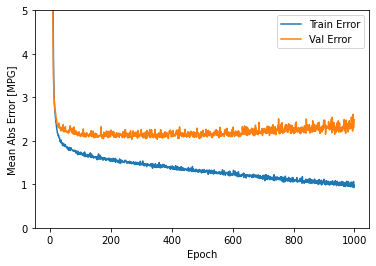

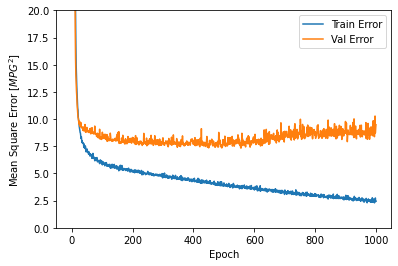

In [19]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.................................................................

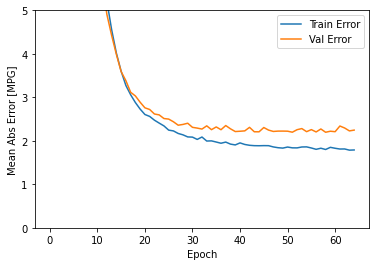

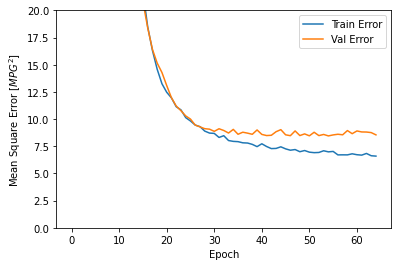

In [20]:
model = build_model()

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.3192 - mae: 1.7633 - mse: 5.3192 - 18ms/epoch - 6ms/step
Testing set Mean Abs Error:  1.76 MPG


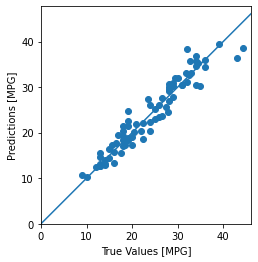

In [22]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

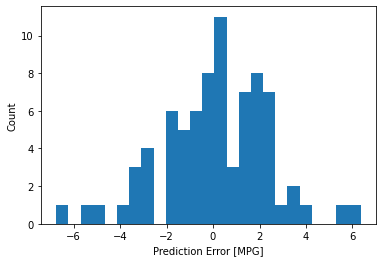

In [23]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")